# Gillespie Algorithm

We have $N$ chemical species $\{S_1,\cdots,S_n\}$ and $M$ chemical reactions between them $\{R_1,\cdots ,R_M\}$

$X_i(t)$ is the amount of molecules (or concentration) of $S_i$. The system is thus described by the vector $\vec x(t)=\{X_1(t),\cdots,X_N(t)\}$.


Each reaction $R_j$ has a state-change vector $\vec v_j = \{v_{1j},\cdots,v_{Nj}\}$, where the quantity $v_{ij}$ is the change that reaction $R_j$ produces on species $S_i$. If the system is in state $\vec x$, reaction $R_j$ changes this state to $\vec x + \vec v_j$.

Each reaction also has a "propensity function" $a_j(\vec x)$, where $a_j(\vec x) dt$ is the probability of the reaction $R_j$ occuring in the time interval $dt$.

The reaction rate equation is:

$$
\frac{d \vec X(t)}{dt} = \sum_{j=1}^M \vec v_j  a_j(\vec X(t))
$$

We define $p_j(\tau,\vec x)$ as the probability (given a state $\vec x$) that the next reaction is $R_j$ and it will occur in a $\tau$ interval. Apparently

$$
p_j(\tau,\vec x) = a_j(\vec x) \exp\left( -\tau a_0(\vec x)\right)
$$

Where $a_0(\vec x)$ is the sum of all the $a_j$s. 

Therefore the stochastic time between reactions is an exponential random varaible with mean $1/a_0(\vec x)$, and the reaction that occurs first can be picked from the $R_j$s with probabilities $a_j(\vec x)/a_0(\vec x)$.

If we include the time as first coordinate on the state vector, $\vec x=\{t,m,r\}$. $x_0=t$, the data can be stored more efficiently.

In [1]:
%run gillespy-numba.py

## Radioactive decay example

In [16]:
c = 0.1

@njit(f8[:](f8[:]))
def a(x_vec):
    return np.array([c*x_vec[1]])

@njit(f8[:,:](f8[:]))
def v(x_vec):
    # first column *must* be zeros
    return np.array([
        [0.,-1.] # decay of an atom
    ])

x0 = np.array([0.,1e3]) # t_0=0, x(0)=1k atoms
times = np.arange(0.,60.,5.)

In [17]:
%time model = GillespieModel(a,v)

CPU times: user 4.11 s, sys: 4.08 ms, total: 4.12 s
Wall time: 4.19 s


In [30]:
%%time 

Nsys = 100

means = model.multi_system_evolve(np.array([x0 for _ in range(Nsys)]),times)
data = model.multi_system_step(np.array([x0 for _ in range(Nsys)]),1000)
all_data = data.reshape((data.shape[0]*data.shape[1],data.shape[2]))

CPU times: user 263 ms, sys: 0 ns, total: 263 ms
Wall time: 267 ms


(0.0, 55.0)

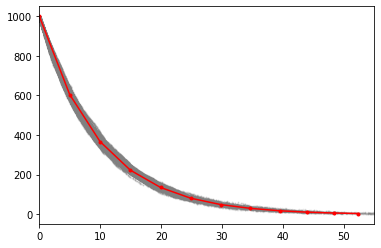

In [31]:
plt.scatter(*all_data.T[[0,1]],s=1,color='gray',alpha=.1)
plt.plot(*np.mean(means,axis=0).T[[0,1]],'.-r')
plt.xlim([min(times),max(times)])

## mARN and protein simple model example

$\vec x = \{t, m,p\}$, where $m$ is molecules of mARN and $p$ of proteins.

In [236]:
cm = 1.0
dm = 0.2
cp = 50
dp = 0.03333333

@njit(f8[:](f8[:]))
def a(x_vec):
    return np.array([cm, dm*x_vec[1], cp*x_vec[1], dp*x_vec[2]])

@njit(f8[:,:](f8[:]))
def v(x_vec):
    # first column *must* be zeros
    return np.array([
        [0.,  1.,  0.], # creation of mRNA
        [0., -1.,  0.], # degradation of mRNA
        [0.,  0.,  1.], # creation of protein
        [0.,  0., -1.], # degradation of protein
    ])

x0 = np.array([0.,0.,0.])
times = np.arange(0.,190.,40.)
dt = 0.1

In [237]:
%time model = GillespieModel(a,v)

CPU times: user 5.06 s, sys: 12.7 ms, total: 5.07 s
Wall time: 5.21 s


In [238]:
data = model.multi_system_step(np.array([x0 for _ in range(10)]),60_000)
all_data = data.reshape((data.shape[0]*data.shape[1],data.shape[2]))

In [239]:
%time means = model.multi_system_evolve(np.array([x0 for _ in range(100)]),times)

CPU times: user 10.8 s, sys: 129 ms, total: 10.9 s
Wall time: 11.2 s


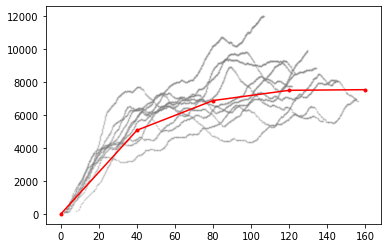

In [240]:
plt.scatter(*all_data[::100].T[[0,2]],s=1,color='gray',alpha=.2)
plt.plot(*np.mean(means,axis=0).T[[0,2]],'.-r')

# Simplest division

$$
\vec x = \{ t,b_{acc}\} 
$$

$$
\dot P = k (s_0 b_{acc})^\lambda \exp(\mu \lambda t) 
$$

only one reaction:
$$
b_{acc} \to b_{acc}/2
$$

In [228]:
k = 15.
λ = 2.0
μ = np.log(2.0)
s0 = 1.0

@njit(f8[:](f8[:]))
def a(x_vec):
    return np.array([
        k*(s0*x_vec[1])**λ * np.exp(μ*λ*x_vec[0])
    ])

@njit(f8[:,:](f8[:]))
def v(x_vec):
    # first column *must* be zeros
    return np.array([
        [0.,-x_vec[1]*0.5] # division
    ])

x_0 = np.array([0.,1.0]) 


def size_evaluate(t_simulation,bacc,times):
    r = np.zeros_like(times)
    for i in range(len(times)):
        j = np.searchsorted(t_simulation,times[i],side='right') 
        r[i] = s0*bacc[j-1] * np.exp(μ*times[i])
    return r 

In [229]:
%time model = GillespieModel(a,v)

CPU times: user 4.25 s, sys: 15.8 ms, total: 4.26 s
Wall time: 4.32 s


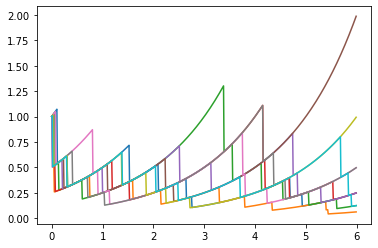

In [231]:
plot_time = np.arange(0.,6.,0.01)

for i in range(10):
    sample = model.single_system_step(x_0,100)
    plt.plot(plot_time,size_evaluate(*sample.T,plot_time))
#plt.yscale('log')

# Random $b$ division

In [263]:
γ = 10.0 # beta distribution parameter
k = 1.
λ = 1.0 
μ = np.log(2.0)
s0 = 1.0

@njit(f8[:](f8[:]))
def a(x_vec):
    return np.array([
        k*(s0*x_vec[1])**λ * np.exp(μ*λ*x_vec[0])
    ])

@njit(f8[:,:](f8[:]))
def v(x_vec):
    b_new = np.random.beta(γ,γ)
    # first column *must* be zeros
    return np.array([
        [0.,-x_vec[1]*b_new] # division
    ])

x_0 = np.array([0.,1.0]) 

In [264]:
%time model = GillespieModel(a,v)

CPU times: user 6.01 s, sys: 519 ms, total: 6.53 s
Wall time: 12.6 s


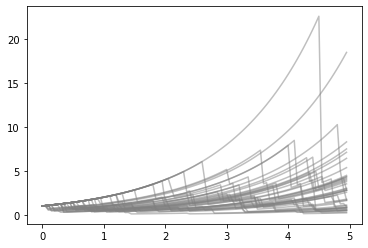

In [272]:
plot_time = np.arange(0.,5.,0.05)

for i in range(40):
    sample = model.single_system_step(x_0,1000)
    plt.plot(plot_time,size_evaluate(*sample.T,plot_time),c='gray',alpha=0.5)

#plt.ylim([0,5])
#plt.yscale('log')

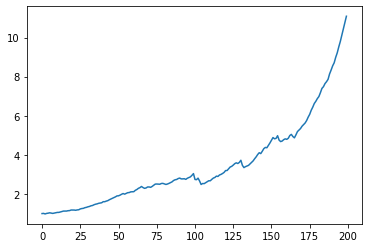

In [266]:
plt.plot(np.mean([size_evaluate(*model.single_system_step(x_0,5000).T,plot_time) for _ in range(100)],axis=0))